In [3]:
%load_ext autoreload
%autoreload 2
from targets.conditional_density_estimation_target import *

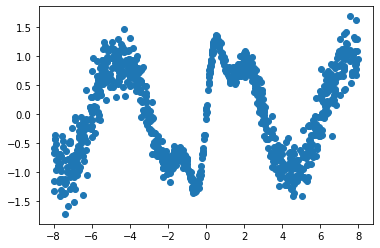

In [11]:
target = Wave()
D_theta = target.sample_prior(1000)
D_x = target.simulate(D_theta)
fig = plt.scatter(D_theta.squeeze(-1).numpy(), D_x.squeeze(-1).numpy())
plt.show()

torch.Size([1])


(array([  6.,  28.,  90., 170., 245., 237., 146.,  56.,  16.,   6.]),
 array([1.1038331, 1.1447396, 1.1856463, 1.2265528, 1.2674595, 1.3083661,
        1.3492726, 1.3901793, 1.4310858, 1.4719925, 1.512899 ],
       dtype=float32),
 <BarContainer object of 10 artists>)

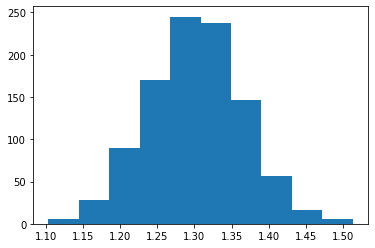

In [12]:
theta_0 = torch.tensor([.5])
print(theta_0.shape)
num_observations = 1000
x0 = target.simulate(theta_0.unsqueeze(0).repeat(num_observations,1))
plt.figure()
plt.hist(x0.detach().numpy())

In [31]:
import torch
from torch import nn
from torch.distributions import Categorical
from tqdm import tqdm

from models_dif.multivariate_normal_reference import MultivariateNormalReference
from models_dif.softmax_weight import SoftmaxWeight

class ConditionalLocationScale(nn.Module):
    def __init__(self, K, p, d, hidden_dimensions):
        super().__init__()
        self.K = K
        self.p = p
        self.d = d

        self.network_dimensions = [self.d] + hidden_dimensions + [2*self.K*self.p]
        network = []
        for h0, h1 in zip(self.network_dimensions, self.network_dimensions[1:]):
            network.extend([nn.Linear(h0, h1),nn.Tanh(),])
        network.pop()
        self.f = nn.Sequential(*network)

    def backward(self, z, theta):
        assert z.shape[:-1]==theta.shape[:-1], 'number of z samples does not match the number of theta samples'
        desired_size = list(z.shape)
        desired_size.insert(-1, self.K)
        Z = z.unsqueeze(-2).expand(desired_size)
        new_desired_size = desired_size
        new_desired_size[-1] = 2*self.p
        out = torch.reshape(self.f(theta), new_desired_size)
        m, log_s = out[...,:self.p], out[...,self.p:]
        return Z * torch.exp(log_s).expand_as(Z) + m.expand_as(Z)

    def forward(self, x, theta):
        assert x.shape[:-1]==theta.shape[:-1], 'number of x samples does not match the number of theta samples'
        desired_size = list(x.shape)
        desired_size.insert(-1, self.K)
        X = x.unsqueeze(-2).expand(desired_size)
        new_desired_size = desired_size
        new_desired_size[-1] = 2*self.p
        out = torch.reshape(self.f(theta), new_desired_size)
        m, log_s = out[...,:self.p], out[...,self.p:]
        return (X-m.expand_as(X))/torch.exp(log_s).expand_as(X)

    def log_det_J(self,x, theta):
        desired_size = list(x.shape)
        desired_size.insert(-1, self.K)
        X = x.unsqueeze(-2).expand(desired_size)
        new_desired_size = desired_size
        new_desired_size[-1] = 2*self.p
        log_s = torch.reshape(self.f(theta), new_desired_size)[..., self.p:]
        return -log_s.sum(-1)

class ConditionalDIFDensityEstimator(nn.Module):
    def __init__(self, x_samples, theta_samples,x0,prior_theta, K, hidden_dimensions):
        super().__init__()
        self.x_samples = x_samples
        self.theta_samples = theta_samples
        self.x0 = x0
        self.prior = prior_theta
        self.p = self.x_samples.shape[-1]
        self.d = self.theta_samples.shape[-1]
        self.num_samples = x_samples.shape[0]
        assert theta_samples.shape[0] == self.num_samples, 'number of X samples does not match the number of theta samples'
        self.K = K

        self.reference = MultivariateNormalReference(self.p)

        self.w = SoftmaxWeight(self.K, self.p+self.d, hidden_dimensions)

        self.T = ConditionalLocationScale(self.K, self.p, self.d, hidden_dimensions)

        self.loss_values = []

    def compute_log_v(self,x, theta):
        assert x.shape[:-1] == theta.shape[:-1], 'wrong shapes'
        theta_unsqueezed = theta.unsqueeze(-2).repeat(1, self.K, 1)
        z = self.T.forward(x, theta)
        log_v = self.reference.log_density(z) + torch.diagonal(self.w.log_prob(torch.cat([z, theta_unsqueezed], dim = -1)), 0, -2, -1) + self.T.log_det_J(x, theta)
        return log_v - torch.logsumexp(log_v, dim = -1, keepdim= True)

    def sample_latent(self,x, theta):
        assert x.shape[:-1] == theta.shape[:-1], 'wrong shapes'
        z = self.T.forward(x, theta)
        pick = Categorical(torch.exp(self.compute_log_v(x, theta))).sample()
        return z[range(z.shape[0]), pick, :]

    def log_density(self, x, theta):
        assert x.shape[:-1] == theta.shape[:-1], 'wrong shapes'
        desired_size = list(theta.shape)
        desired_size.insert(-1, self.K)
        theta_unsqueezed = theta.unsqueeze(-2).expand(desired_size)
        z = self.T.forward(x, theta)
        return torch.logsumexp(self.reference.log_density(z) + torch.diagonal(self.w.log_prob(torch.cat([z, theta_unsqueezed], dim = -1)), 0, -2, -1)+ self.T.log_det_J(x, theta),dim=-1)

    def sample_model(self, theta):
        with torch.no_grad():
            z = self.reference.sample(theta.shape[0])
            x = self.T.backward(z, theta)
            pick = Categorical(torch.exp(self.w.log_prob(torch.cat([z, theta], dim = -1)))).sample()
        return x[range(x.shape[0]), pick, :]

    def loss(self, batch_x, batch_theta):
        batch_theta_unsqueezed = batch_theta.unsqueeze(-2).repeat(1, self.K, 1)
        z = self.T.forward(batch_x, batch_theta)
        return -torch.sum(torch.logsumexp(self.reference.log_density(z) + torch.diagonal(self.w.log_prob(torch.cat([z, batch_theta_unsqueezed], dim = -1)), 0, -2, -1) + self.T.log_det_J(batch_x, batch_theta), dim=-1))
    
    def train(self, epochs,batch_size= None,lr = 5e-3):
        self.para_list = list(self.parameters())
        self.optimizer = torch.optim.Adam(self.para_list, lr=lr, weight_decay=1e-6)

        if batch_size is None:
            batch_size = self.x_samples.shape[0]
        dataset = torch.utils.data.TensorDataset(self.x_samples, self.theta_samples)
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.to(device)
        
        theta_values = []

        pbar = tqdm(range(epochs))
        for t in pbar:
            dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
            for i, batch in enumerate(dataloader):
                x, theta = batch[0].to(device), batch[1].to(device)
                self.optimizer.zero_grad()
                batch_loss = self.loss(x, theta)
                batch_loss.backward()
                self.optimizer.step()
            with torch.no_grad():
                iteration_loss = torch.tensor([self.loss(batch[0].to(device), batch[1].to(device)) for i, batch in enumerate(dataloader)]).mean().item()
            self.loss_values.append(iteration_loss)
            pbar.set_postfix_str('loss = ' + str(round(iteration_loss,6)) + ' ; device: ' + str(device))
        self.to(torch.device('cpu'))

    def train_joint(self, epochs,batch_size= None,lr = 5e-3, initial_theta = None):
        if initial_theta is None:
            self.current_theta = nn.Parameter(self.prior.sample().requires_grad_())
        else:
            self.current_theta = nn.Parameter(initial_theta.requires_grad_())
        self.para_list = list(self.parameters())
        self.optimizer = torch.optim.SGD(self.para_list, lr=lr, weight_decay=1e-6)

        if batch_size is None:
            batch_size = self.x_samples.shape[0]
        dataset = torch.utils.data.TensorDataset(self.x_samples, self.theta_samples)
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.to(device)
        theta_values = []

        pbar = tqdm(range(epochs))
        for t in pbar:
            dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
            for i, batch in enumerate(dataloader):
                x, theta = batch[0].to(device), batch[1].to(device)
                self.optimizer.zero_grad()
                batch_loss = (self.loss(x, theta) - torch.sum(self.log_density(x0.to(device).unsqueeze(1).repeat(1, self.current_theta.shape[0],1), self.current_theta.to(device).unsqueeze(0).repeat(x0.shape[0],1,1)), dim = 0) + torch.sum(torch.nn.utils.parameters_to_vector(self.para_list)*torch.sqrt(torch.tensor(2/lr))*torch.randn_like(torch.nn.utils.parameters_to_vector(self.para_list))))/self.x_samples.shape[0]
                batch_loss.backward()
                self.optimizer.step()
            with torch.no_grad():
                iteration_loss = torch.tensor([self.loss(batch[0].to(device), batch[1].to(device)) for i, batch in enumerate(dataloader)]).mean().item()
            self.loss_values.append(iteration_loss)
            pbar.set_postfix_str('loss = ' + str(round(iteration_loss,6)) + ' ; device: ' + str(device) + ' , current_theta = ' + str(self.current_theta.item()))
            theta_values.append(self.current_theta.to(torch.device('cpu')))
        self.to(torch.device('cpu'))
        return torch.cat(theta_values)

In [32]:
dif = ConditionalDIFDensityEstimator(D_x,D_theta,x0, torch.distributions.MultivariateNormal(torch.zeros(1), torch.eye(1)),1,[32,32])
dif.train(1000, lr= 1e-2)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:19<00:00, 50.22it/s, loss = -292.153442 ; device: cuda]


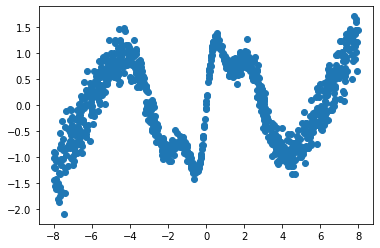

In [33]:
new_x = dif.sample_model(D_theta)
plt.scatter(D_theta.numpy(), new_x.numpy())
plt.show()

In [34]:
from samplers import IMH
sampler = IMH(lambda theta: torch.sum(dif.log_density(x0.unsqueeze(1).repeat(1,theta.shape[0],1), theta.unsqueeze(0).repeat(x0.shape[0],1,1)), dim = 0),1,None,500)
samples = sampler.sample(100)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:54<00:00,  1.84it/s, acceptance = tensor(0.0100)]


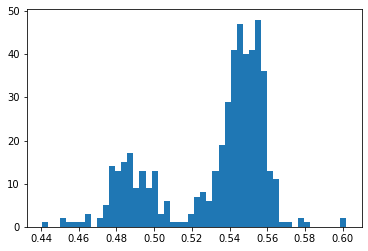

In [35]:
plt.hist(samples.numpy(), bins = 50)
plt.show()

In [36]:
theta_values = dif.train_joint(5000, lr = 1e-5, initial_theta=samples[:1])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [01:49<00:00, 45.50it/s, loss = -288.766022 ; device: cuda , current_theta = 0.5233170390129089]


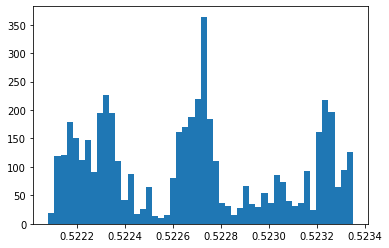

In [37]:
plt.hist(theta_values.detach().numpy(), bins=50)
plt.show()

In [38]:
import pyro
ess = pyro.ops.stats.effective_sample_size(theta_values, chain_dim = 1, sample_dim = 0)

In [39]:
print(ess)

tensor(2.6404, grad_fn=<SqueezeBackward1>)


In [ ]:
print(theta_values.shape)